# Analysis and visualisation of experiment results
## Imports

In [8]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [9]:
import copy
from collections import defaultdict
from pathlib import Path
import math

import hyperopt
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import pandas as pd
import plotly.express as ex
import plotly.graph_objects as go
import plotly.io as pio
import pytorch_lightning as tl
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.linear_model import Lasso, ARDRegression, Ridge
import torch
from torch_geometric.loader import DataLoader
import pickle

from src import config
from src.data.hts import DatasetUsage
from src.data.scaling import fit_label_scaler, StandardScaler
from src.data.utils import get_dataset, BasicSplit
from src.logging import read_json_file
from src.models.metrics import DEFAULT_ACCURACY_METRICS, DEFAULT_EXPLAINABILITY_METRICS
from src.nas.hyperopt import construct_search_space, _convert_to_gnn_architecture
from src.models.gnns import GNN, ActivationFunction, GNNLayerType, string_to_architecture
from src.nas.proxies import Ensemble, DEFAULT_PROXIES, ProxyCollection, ZiCo
from src.models.training import LitGNN, HyperParameters

C:\Users\MrMil\miniconda3\envs\automl-drug-discovery\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
#plt.rcParams['savefig.dpi'] = 150

In [11]:
plt.rc('pdf',fonttype = 42)
plt.rc('ps',fonttype = 42)

def apply_font(ax):
    ticks = ax.get_xticklabels() + ax.get_yticklabels()
    for t in ticks:
        t.set_fontname('Times New Roman') 
        
    txt = ax.get_xlabel()
    txt_obj = ax.set_xlabel(txt)
    txt_obj.set_fontname('Times New Roman')

    txt = ax.get_ylabel()
    txt_obj = ax.set_ylabel(txt)
    txt_obj.set_fontname('Times New Roman')

    txt = ax.get_title()
    txt_obj = ax.set_title(txt)
    txt_obj.set_fontname('Times New Roman')

## Utils

In [12]:
def _get_log_dir(dataset: str, experiment: str, data_usage: str) -> Path:
    return config.LOG_DIR / dataset / data_usage / experiment

img_ext = '.pdf'

In [13]:
datasets = ['AID1445', 'AID504329', 'AID624330', 'AID1465', 'AID1431-873', 'AID449756-435005', 'AID504313-2732', 'AID1259350-1224905']
average_datasets = ['AID1445', 'AID504329', 'AID624330', 'AID1465', 'AID1431-873', 'AID449756-435005', 'AID504313-2732']
metric_names = ['MeanAbsoluteError', 'RootMeanSquaredError', 'MaxError', 'PearsonCorrCoefSquared', 'ConceptCompleteness']
metric_nice_names = {'MeanAbsoluteError': 'MAE', 'RootMeanSquaredError': 'RMSE', 'MaxError': 'Max Error', 'PearsonCorrCoefSquared': '$R^2$', 'ConceptCompleteness': 'ConceptCompleteness'}
proxy_names = ['NumParams', 'SynFlow', 'GradientNorm', 'JacobianCovariance', 'Snip', 'ZiCo', 'Grasp', 'Fisher', 'LatentSparsityGrad', 'ConceptPurityGrad']
METRIC_HIGHER_IS_BETTER = {
    'MeanAbsoluteError': False,
    'RootMeanSquaredError': False,
    'MaxError': False,
    'PearsonCorrCoefSquared': True,
    'ConceptCompleteness': True,
}
dataset_correlations = {
    'AID1445': ('0.78', '6.06e-137'),
    'AID504329': ('0.79', '7.85e-192'),
    'AID624330': ('0.66', '2.30e-198'),
    'AID1465': ('-0.14', '5.42e-1'),
    'AID1431-873': ('0.08', '8.22e-3'),
    'AID449756-435005': ('0.25', '3.59e-27'),
    'AID504313-2732': ('-0.09', '5.84e-3'),
    'AID1259350-1224905': ('0.41', '2.11e-24')
}

In [14]:
DEFAULT_PARAMS = HyperParameters(
    random_seeds=0,
    dataset_split=BasicSplit(0.1, 0.9),
    batch_size=32,
    early_stop_patience=30,
    early_stop_min_delta=0,
    lr=1e-4,
    max_epochs=100,
    num_workers=0,
    label_scaler=StandardScaler,
    precision='medium'
)

In [15]:
def get_all_baseline_results(dataset, dataset_usage) -> pd.DataFrame:
    log_dir = _get_log_dir(dataset, 'baseline', dataset_usage)
    data = defaultdict(list)
    for p in log_dir.glob("*"):
        if p.is_dir():
            trial_id = p.name
            if not (p / 'metrics.json').exists():
                continue
            trial_metrics = read_json_file(p, 'metrics.json')
            # trial_proxies = read_json_file(p, 'proxies.json')
            for version in trial_metrics:
                data['trial'].append(trial_id)
                data['version'].append(version)
                for name, metric in trial_metrics[version].items():
                    data[name].append(metric)
                # for name, proxy in trial_proxies[version].items():
                #     data[name].append(proxy)
    return pd.DataFrame(data)
                
    

In [16]:
def load_samples(dataset: str, include_explain=False):
    filename = 'sampled_results_explain.pt' if include_explain else 'sampled_results.pt'
    path = _get_log_dir(dataset, filename, 'DROnly')
    return torch.load(path)

In [17]:
def load_trials(dataset: str, experiment: str):
    trials_path = _get_log_dir(dataset, experiment, 'DROnly') / 'trials.pkl'
    with open(trials_path, 'rb') as file:
        return pickle.load(file)
    
def load_best_nas_architecture(dataset: str, experiment: str):
    path = _get_log_dir(dataset, experiment, 'DROnly')
    if (path / 'best_architecture.json').exists():
        filename = 'best_architecture.json'
    else:
        path = path / 'best_architecture'
        filename = 'metrics.json'
    return read_json_file(path, filename)

In [18]:
def get_best_baseline_model(dataset: str, dataset_usage: str):
    exp_path = _get_log_dir(dataset, 'baseline', dataset_usage)
    df = pd.read_csv(exp_path / 'metrics.csv', sep=';', index_col=0, header=[0,1])
    idx = df['PearsonCorrCoefSquared']['mean'].idxmax()
    model_str = df['architectures'].iloc[idx].values[0]
    exp_path = exp_path / str(idx)
    metrics = read_json_file(exp_path, 'metrics.json')
    best_k = None
    best_v = -1
    for k, v in metrics.items():
        if v['PearsonCorrCoefSquared'] > best_v:
            best_k = k
            best_v = v['PearsonCorrCoefSquared']
    ckpt_path = exp_path / best_k / 'checkpoints' / 'last.ckpt'
    model = GNN(string_to_architecture(model_str))
    print(model_str)
    return LitGNN.load_from_checkpoint(
        ckpt_path,
        model=model,
        label_scaler=StandardScaler(),
        metrics=DEFAULT_ACCURACY_METRICS,
        explainability_metrics=DEFAULT_EXPLAINABILITY_METRICS
    )
    

In [19]:
def get_run_result(dataset: str, experiment: str, dataset_usage: str):
    exp_path = _get_log_dir(dataset, experiment, dataset_usage)
    return read_json_file(exp_path / 'best_model', 'metrics.json')
    

In [20]:
def calculate_confidence_interval(losses: list[torch.Tensor]):
    stacked_losses = torch.stack(losses, dim=0)
    means = torch.mean(stacked_losses, dim=0)
    margin_of_error = 1.96 * torch.std(stacked_losses, dim=0) / math.sqrt(len(datasets))
    lower_bound = means - margin_of_error
    upper_bound = means + margin_of_error
    return means, lower_bound, upper_bound

In [21]:
def scale_01(tens: torch.Tensor):
    return (tens - tens.min()) / (tens.max() - tens.min())

## Baseline Results
### R2 Box Plots

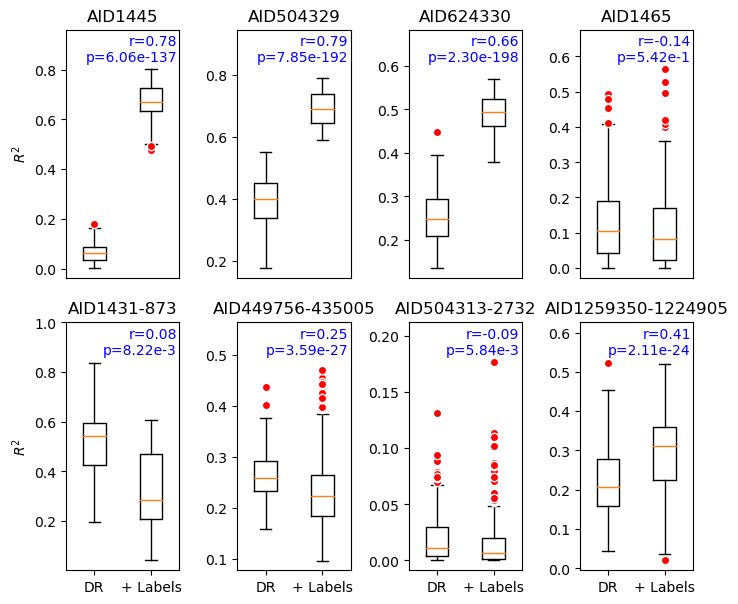

In [23]:
fig, axs = plt.subplots(2, 4, figsize=(7, 6))
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
fig.tight_layout()

axs[0][0].set_ylabel("$R^2$")
axs[1][0].set_ylabel("$R^2$")

for i, (ax, dataset) in enumerate(zip(axs.flatten(), datasets)):
    dr_df = get_all_baseline_results(dataset, 'DROnly')
    dr_with_labels_df = get_all_baseline_results(dataset, 'DRWithSDLabels')
    df = pd.DataFrame({'DR': dr_df['PearsonCorrCoefSquared'], '+ Labels': dr_with_labels_df['PearsonCorrCoefSquared']})
    ax.set_title(dataset)
    ax.boxplot(df, flierprops=red_circle, labels=df.columns, widths=0.4)
    if i < 4:
        ax.set_xticks([])
    
    ymax = max(dr_df['PearsonCorrCoefSquared'].max(), dr_with_labels_df['PearsonCorrCoefSquared'].max())
    ax.set_ylim(top=ymax * 1.2)
    ax.text(
        0.98, 0.98,
        f"r={dataset_correlations[dataset][0]}\np={dataset_correlations[dataset][1]}",
        transform = ax.transAxes,
        color='blue', horizontalalignment='right', verticalalignment='top',
    )

fig.savefig(config.FIGURES_DIR / ('baseline_r2_box_plot' + img_ext), bbox_inches='tight')

### Loss Explainability Relationship

In [24]:
metrics = defaultdict(list)
scaler = StandardScaler()
for dataset in datasets:
    df = get_all_baseline_results(dataset, 'DROnly')
    for metric in ['PearsonCorrCoefSquared', 'ConceptCompleteness', 'RootMeanSquaredError']:
        metrics[metric].extend(scaler.fit_transform(torch.tensor(df[metric].to_numpy()).reshape(-1, 1)))
for metric in metrics:
    metrics[metric] = np.array([m.item() for m in metrics[metric]])

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
fig.tight_layout()

x = - metrics['ConceptCompleteness']
y = metrics['RootMeanSquaredError']

ax.set_ylabel('MSE Z-Score')
ax.set_xlabel('Concept Completeness Z-Score')
ax.scatter(x, y, s=1)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')
ax.text(0.6, 0.3, "r=0.49", transform = ax.transAxes, color='crimson', size='large')
fig.savefig(config.FIGURES_DIR / 'loss_explainability_relationship.png', bbox_inches='tight')

### Label and Prediction Distributions

In [16]:
dataset = 'AID504329'
raw_dataset = get_dataset(dataset, dataset_usage=DatasetUsage.DROnly)
label_scaler = fit_label_scaler(raw_dataset, StandardScaler)
dataloader = DataLoader(raw_dataset, batch_size=len(raw_dataset))
batch = next(iter(dataloader))

In [17]:
best_model = get_best_baseline_model(dataset, 'DROnly').cpu()
preds = best_model.model(batch.x, batch.edge_index, batch.batch).detach()
scaled_preds = label_scaler.inverse_transform(preds).flatten()

GNNArchitecture(Layers: [GIN, GIN], Features: [113, 128, 128], Activation Functions: [ReLU, ReLU]Batch Normalise: [True, True], Pool Function: ADD, Regression Layer: RegressionArchitecture(Layers: [Linear, Linear], Features: [128, 64, 1], Activation Functions: [ReLU, None]Batch Normalise: [True, False]))


In [19]:
nas_result = load_best_nas_architecture(dataset, 'hyperopt_baseline_tpe')
nas_model = GNN(string_to_architecture(list(nas_result.keys())[0]))
lit_model = LitGNN(nas_model, DEFAULT_PARAMS, DEFAULT_ACCURACY_METRICS, DEFAULT_EXPLAINABILITY_METRICS, label_scaler)
trainer = tl.Trainer(
    default_root_dir='.',
    accelerator='gpu',
    devices=1,
    max_epochs=100,
    enable_checkpointing=False,
    logger=False,
    enable_progress_bar=False,
    enable_model_summary=False,
)

trainer.fit(lit_model, dataloader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\MrMil\miniconda3\envs\automl-drug-discovery\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\MrMil\miniconda3\envs\automl-drug-discovery\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.


In [20]:
best_preds = nas_model(batch.x, batch.edge_index, batch.batch).detach()
scaled_best_preds = label_scaler.inverse_transform(best_preds).flatten()

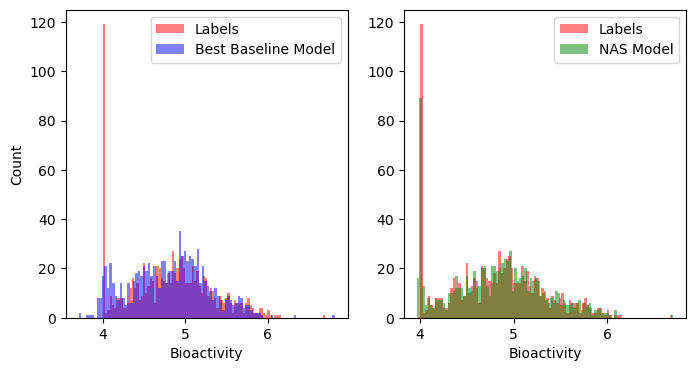

In [21]:
# histograms
num_bins = 100
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].set_ylabel('Count')
for ax in axs:
    ax.set_xlabel('Bioactivity')
axs[0].hist(raw_dataset.data.y, bins=num_bins, alpha=0.5, label='Labels', color='red')
axs[1].hist(raw_dataset.data.y, bins=num_bins, alpha=0.5, label='Labels', color='red')
axs[0].hist(scaled_preds.flatten(), bins=num_bins, alpha=0.5, label='Best Baseline Model', color='blue')
axs[1].hist(scaled_best_preds.flatten(), bins=num_bins, alpha=0.5, label='NAS Model', color='green')
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

fig.savefig(config.FIGURES_DIR / ('distribution' + img_ext), bbox_inches='tight')

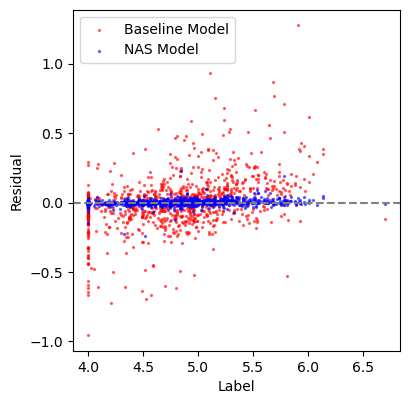

In [22]:
# Residual plot
fig, ax = plt.subplots(figsize=(4, 4))
fig.tight_layout()
x = raw_dataset.data.y
y = scaled_preds.flatten()
best_y = scaled_best_preds.flatten()
y = x - y
best_y = x - best_y
ax.set_ylabel('Residual')
ax.set_xlabel('Label')
#ax.set_ylim(-0.005, 0.005)
ax.scatter(x, y, color='red', alpha=0.5,s=2, label='Baseline Model')
ax.scatter(x, best_y, color='blue', alpha=0.5, s=2, label='NAS Model')
ax.axhline(y=0, color='grey', linestyle='--')
ax.legend(loc='best')
fig.savefig(config.FIGURES_DIR / ('residual_plot' + img_ext), bbox_inches='tight')

### Label Scaling

In [23]:
dataset = 'AID1445'
raw_dataset = get_dataset(dataset, dataset_usage=DatasetUsage.DROnly)
label_scaler = fit_label_scaler(raw_dataset, StandardScaler)
dataloader = DataLoader(raw_dataset, batch_size=len(raw_dataset))
batch = next(iter(dataloader))

In [24]:
nas_result = load_best_nas_architecture(dataset, 'hyperopt_baseline_tpe')
model = GNN(string_to_architecture(list(nas_result.keys())[0]))
untrained_preds = model(batch.x, batch.edge_index, batch.batch).detach()
#scaled_untrained_preds = label_scaler.inverse_transform(untrained_preds)
scaled_labels = label_scaler.transform(raw_dataset.data.y.reshape(1, -1))

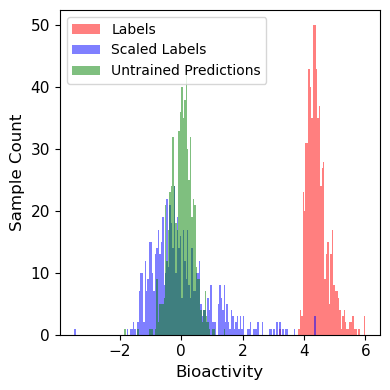

In [25]:
bins = np.linspace(
    min(scaled_labels.min(), untrained_preds.min()),
    max(untrained_preds.max(), raw_dataset.data.y.max()),
    200
)
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_ylabel('Sample Count', fontsize=12)
ax.set_xlabel('Bioactivity', fontsize=12)
ax.tick_params(labelsize=11)
ax.hist(raw_dataset.data.y, bins=bins, alpha=0.5, label='Labels', color='red')
ax.hist(scaled_labels.flatten(), bins=bins, alpha=0.5, label='Scaled Labels', color='blue')
ax.hist(untrained_preds.flatten(), bins=bins, alpha=0.5, label='Untrained Predictions', color='green')
plt.legend(loc='best')
fig.tight_layout()
fig.savefig(config.FIGURES_DIR / ('label_scaling' + img_ext), bbox_inches='tight')

## NAS

### Table of Results

In [53]:
loss_experiments = [
    'hyperopt_baseline',
    'hyperopt_baseline_tpe',
    'hyperopt_baseline_tpe_noisy',
    'hyperopt_proxy_ensemble',
    'hyperopt_proxy_ensemble_long',
    'hyperopt_proxy_rand_ensemble_long',
    'hyperopt_proxy_ensemble_continue',
]
explainability_experiments = [
    'hyperopt_baseline_explainability',
    'hyperopt_baseline_tpe_explainability',
    'hyperopt_baseline_tpe_noisy_explainability',
    'hyperopt_proxy_ensemble_explainability',
    'hyperopt_proxy_ensemble_explainability_long',
    'hyperopt_proxy_rand_ensemble_explainability_long',
    'hyperopt_proxy_ensemble_explainability_continue',
]

# target = 'PearsonCorrCoefSquared'
# experiments = loss_experiments
target = 'ConceptCompleteness'
experiments = explainability_experiments
metrics_to_save = ['PearsonCorrCoefSquared', 'MaxError', 'ConceptCompleteness']

metrics = {}
baseline_metrics = {}
for dataset in average_datasets:
    dataset_metrics = {}
    results = get_all_baseline_results(dataset, 'DROnly')
    for metric in metrics_to_save:
        dataset_metrics[metric] = results[metric]
    baseline_metrics[dataset] = dataset_metrics
    
for experiment in experiments:
    experiment_metrics = defaultdict(dict)
    for dataset in average_datasets:
        results = load_best_nas_architecture(dataset, experiment)
        trials = load_trials(dataset, experiment)
        dataset_metrics = {}
        for metric in metrics_to_save:
            nas_m = list(results.values())[0].get(metric)
            trials_ms = [t['result']['metrics'].get(metric) for t in trials.trials]
            trials_ms = [m for m in trials_ms if m is not None]
            if not trials_ms:
                best_m = nas_m
            elif metric == 'PearsonCorrCoefSquared':
                trial_m = max(trials_ms)
                best_m = max(nas_m, trial_m)
            else:
                trial_m = min(trials_ms)
                best_m = min(nas_m, trial_m)
            experiment_metrics[metric][dataset] = best_m
    metrics[experiment] = experiment_metrics

In [54]:
baseline_means = defaultdict(dict)
baseline_cis = defaultdict(dict)
for dataset, dataset_results in baseline_metrics.items():
    for metric, values in dataset_results.items():
        vs = np.array(values)
        baseline_means[metric][dataset] = vs.mean()
        baseline_cis[metric][dataset] = 1.96 * vs.std() / math.sqrt(len(vs))

In [55]:
print_str = "baseline"
print(metrics_to_save)
for metric in metrics_to_save:
    mean = np.array(list(baseline_means[metric].values())).mean()
    ci = np.array(list(baseline_cis[metric].values())).mean()
    print_str += ' & %.3g \pm %.3g' % (mean, ci)
print(print_str)

for experiment, results in metrics.items():
    print_str = experiment
    for metric in metrics_to_save:
        vs = np.array([x for x in results[metric].values()])
        mean = vs.mean()
        ci = 1.96 * vs.std() / math.sqrt(len(average_datasets))
        print_str += r' & {0:.3g} \pm {1:.3g}'.format(mean, ci)
    print(print_str)

['PearsonCorrCoefSquared', 'MaxError', 'ConceptCompleteness']
baseline & 0.234 \pm 0.0106 & 1.27 \pm 0.0339 & 0.155 \pm 0.00294
hyperopt_baseline_explainability & 0.395 \pm 0.123 & 0.778 \pm 0.232 & 0.104 \pm 0.052
hyperopt_baseline_tpe_explainability & 0.413 \pm 0.14 & 1.01 \pm 0.294 & 0.124 \pm 0.0678
hyperopt_baseline_tpe_noisy_explainability & 0.347 \pm 0.134 & 1.04 \pm 0.305 & 0.115 \pm 0.0521
hyperopt_proxy_ensemble_explainability & 0.131 \pm 0.0948 & 1.53 \pm 0.469 & 0.181 \pm 0.0667
hyperopt_proxy_ensemble_explainability_long & 0.122 \pm 0.0805 & 1.46 \pm 0.474 & 0.181 \pm 0.0668
hyperopt_proxy_rand_ensemble_explainability_long & 0.199 \pm 0.131 & 1.36 \pm 0.299 & 0.183 \pm 0.0682
hyperopt_proxy_ensemble_explainability_continue & 0.316 \pm 0.139 & 1.18 \pm 0.378 & 0.135 \pm 0.0657


### Parallel Coordinates

In [26]:
search_space = construct_search_space('simple')
searched_archs = defaultdict(list)
for dataset in datasets:
    losses = []
    trials = load_trials(dataset, 'hyperopt_baseline_tpe')
    for trial in trials.trials:
        spec = hyperopt.base.spec_from_misc(trial['misc'])
        arch = hyperopt.space_eval(search_space, spec)
        searched_archs['No. Layers'].append(arch['layers']['num'])
        layers = {t.name: 0 for t in GNNLayerType}
        for layer in arch['layers']['layer_types']:
            layers[layer.name] += 1
        for t, count in layers.items():
            searched_archs['No. ' + t].append(count)
        searched_archs['Pool Func'].append(arch['pool_func'].name)
        searched_archs['No. Features'].append(arch['layers']['hidden_features'])
    
    r2s = np.array([t['result']['metrics']['PearsonCorrCoefSquared'] for t in trials.trials])
    searched_archs['R2 Z-Score'].extend((r2s - r2s.mean()) /  r2s.std())
    
    conceptcomps = np.array([t['result']['metrics']['ConceptCompleteness'] for t in trials.trials])
    searched_archs['Conc. Comp. Z-Score'].extend(((conceptcomps - conceptcomps.mean()) /  conceptcomps.std()).clip(-6))
                   
searched_architectures = pd.DataFrame(searched_archs)

In [27]:
cat = searched_architectures['Pool Func'].astype('category').cat
searched_architectures['Pooling Function'] = cat.codes
pool_func_text = [cat.categories[i] for i in range(0, 3)]
noise = np.random.normal(0, 0.02, len(searched_architectures))

r2_range = [searched_architectures['R2 Z-Score'].min(), searched_architectures['R2 Z-Score'].max()]
entire_range = r2_range
top_range = [searched_architectures['R2 Z-Score'].quantile(0.9), r2_range[1]]
bottom_range = [r2_range[0], searched_architectures['R2 Z-Score'].quantile(0.1)]

conc_comp = - searched_architectures['Conc. Comp. Z-Score']

layer_dims = [
    dict(
        label=f'No. {t.name}',
        values=searched_architectures[f'No. {t.name}'] + noise,
        range=[0, 3], tickvals=[0, 1, 2, 3]
    ) for t in GNNLayerType
]
dimensions = [
    dict(label='No. Layers', values=searched_architectures['No. Layers'] + noise, range=[1, 3], tickvals=[1, 2, 3]),
    dict(label='No. Features', values=searched_architectures['No. Features'] + noise, range=[0, 256]),
    dict(label='Pooling Function', values=searched_architectures['Pooling Function'] + noise, range=[0, 2], tickvals=[0,1,2], ticktext=pool_func_text),
    *layer_dims,
    dict(label='R2 Z-Score', values=searched_architectures['R2 Z-Score'], range=r2_range, constraintrange=None),
    dict(label='Conc. Comp. Z-Score', values=conc_comp, range=[conc_comp.min(), conc_comp.max()]),
]


fig = go.Figure(
    data=go.Parcoords(
        line=dict(
            color=searched_architectures['R2 Z-Score'],
            colorscale=ex.colors.diverging.Portland,
            showscale=True,
        ),
        dimensions=dimensions,
        labelfont={'size': 22},
        tickfont={'size': 20},
        rangefont={'size': 16},
        labelangle=30
    ),
    layout={'margin': {'t': 160, 'l': 120}}
)

pio.write_image(fig, str(config.FIGURES_DIR / 'parallel_coordinates.pdf'), width=1280, height=720)

### Convergence

In [43]:
rand_losses = []
tpe_losses = []
noisy_losses = []
for dataset in datasets:
    rand_trials = load_trials(dataset, 'hyperopt_baseline')
    tpe_trials = load_trials(dataset, 'hyperopt_baseline_tpe')
    noisy_trials = load_trials(dataset, 'hyperopt_baseline_tpe_noisy')
    rands = torch.tensor([trial['result']['metrics']['PearsonCorrCoefSquared'] for trial in rand_trials]).cummax(0).values
    tpes = torch.tensor([trial['result']['metrics']['PearsonCorrCoefSquared'] for trial in tpe_trials]).cummax(0).values
    noisies = torch.tensor([trial['result']['metrics']['PearsonCorrCoefSquared'] for trial in noisy_trials]).cummax(0).values
    # min_val = min(rands.min(), tpes.min(), noisies.min())
    # max_val = max(rands.max(), tpes.max(), noisies.max()) - min_val
    # rands = (rands - min_val) / max_val
    # tpes = (tpes - min_val) / max_val
    # noisies = (noisies - min_val) / max_val
    rand_losses.append(rands)
    tpe_losses.append(tpes)
    noisy_losses.append(noisies)
    

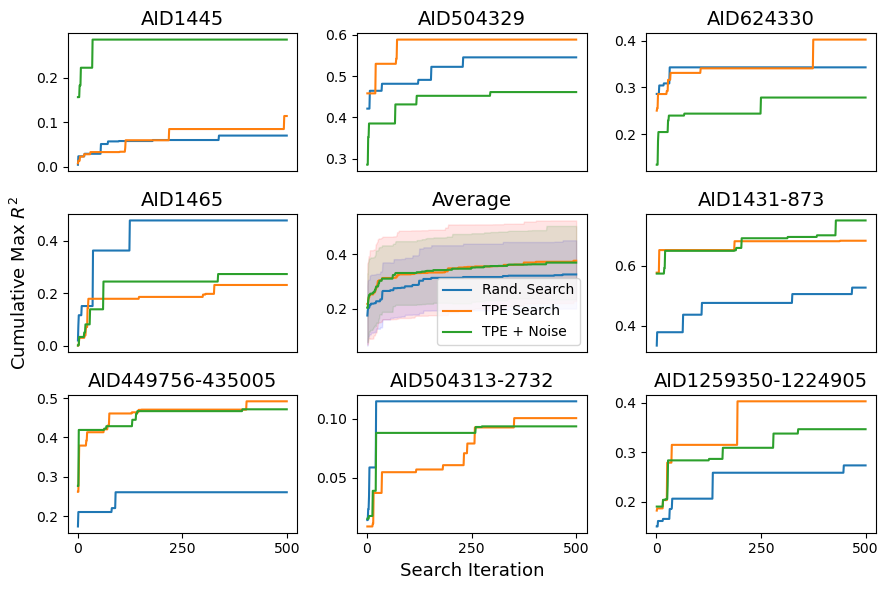

In [ ]:
xs = list(range(1, 501))
fig, axs = plt.subplots(3, 3, figsize=(9, 6))

axs[1][0].set_ylabel('Cumulative Max $R^2$', size=13)
axs[2][1].set_xlabel('Search Iteration', size=13)
fig_idxs = [0, 1, 2, 3, 5, 6, 7, 8]
for i, (ax_i, dataset) in enumerate(zip(fig_idxs, datasets)):
    ax = axs.flatten()[ax_i]
    ax.plot(xs, rand_losses[i])
    ax.plot(xs, tpe_losses[i])
    ax.plot(xs, noisy_losses[i])
    ax.set_title(dataset, size=14)
    if ax_i < 6:
        ax.set_xticks([])
    else:
        ax.set_xticks([0, 250, 500])
        
rand_means, rand_lower, rand_upper = calculate_confidence_interval(rand_losses)
tpe_means, tpe_lower, tpe_upper = calculate_confidence_interval(tpe_losses)
noisy_means, noisy_lower, noisy_upper = calculate_confidence_interval(noisy_losses)
ax = axs[1][1]
ax.set_title('Average', size=14)
ax.plot(xs, rand_means, label='Rand. Search')
ax.fill_between(xs, rand_lower, rand_upper, color='blue', alpha=.1)
ax.plot(xs, tpe_means, label='TPE Search')
ax.fill_between(xs, tpe_lower, tpe_upper, color='red', alpha=.1)
ax.plot(xs, noisy_means, label='TPE + Noise')
ax.fill_between(xs, noisy_lower, noisy_upper, color='green', alpha=.1)
#ax.set_ylim(ymin=0)
ax.set_xticks([])
ax.legend(loc='lower right')

fig.tight_layout()
fig.savefig(config.FIGURES_DIR / ('convergence' + img_ext), bbox_inches='tight')

### Transferability

In [31]:
originals = defaultdict(list)
metrics = defaultdict(list)
confidence_intervals = defaultdict(list)
for target_dataset in datasets:
    for model_dataset in datasets:
        model_result = get_run_result(target_dataset, f'best_model_{model_dataset}', 'DROnly')
        r2s = np.array([v['PearsonCorrCoefSquared'] for v in model_result.values()])
        r2 = r2s.mean()
        ci = 1.96 * r2s.std() / math.sqrt(len(r2s))
        if model_dataset == target_dataset:
            originals[target_dataset] = r2
        else:
            metrics[target_dataset].append(r2)
            confidence_intervals[target_dataset].append(ci)

In [32]:
scaled_metrics = {k: 100 * (np.array(v) - originals[k]) / originals[k]  for k, v in metrics.items()}
scaled_ci = {k: np.array(v) * np.abs(scaled_metrics[k]) / np.abs(np.array(metrics[k])) for k, v in confidence_intervals.items()}

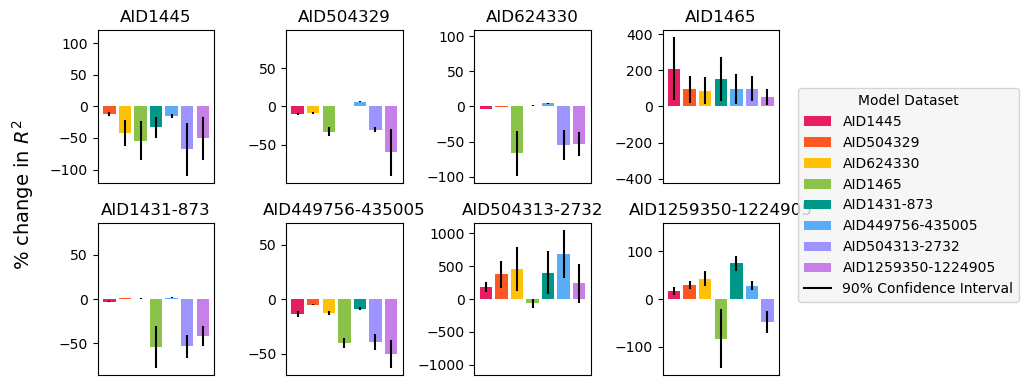

In [34]:
fig, axs = plt.subplots(2, 4, figsize=(8, 4))
xs = list(range(1, len(datasets)))
cs = ['#e81e63', '#ff5722', '#ffc107', '#8bc34a', '#009688', '#59adf6', '#9d94ff', '#c780e8']
cs = {d: c for d, c in zip(datasets, cs)}
for ax, dataset in zip(axs.flatten(), datasets):
    ms = scaled_metrics[dataset]
    ci = scaled_ci[dataset]
    colors = [cs[d] for d in datasets if d != dataset]
    ax.bar(xs, ms, yerr=ci, color=colors)
    ax.set_title(dataset)
    ax.set_xticks([])
    max_abs = max(abs(min(ms - ci)), abs(max(ms + ci))) * 1.1
    ax.set_ylim(-max_abs, max_abs)
legend = [Patch(facecolor=cs[d], label=d) for d in datasets]
legend.append(Line2D([], [], color='black', label="90% Confidence Interval"))
fig.legend(handles=legend, loc='right', bbox_to_anchor=(1.29, 0.5), fancybox=True, title='Model Dataset', facecolor='#f4f4f4', fontsize=10)
fig.supylabel("% change in $R^2$", size=14)
fig.tight_layout()
fig.savefig(config.FIGURES_DIR / ('transferability' + img_ext), bbox_inches='tight')

## Explainability
### Loss-Explainability Trade-off

In [26]:
metrics_to_save = ['PearsonCorrCoefSquared', 'ConceptCompleteness', 'MaxError']
experiments = [
    'hyperopt_baseline_tpe_explainability',
    'hyperopt_joint_025_loss_explainability',
    'hyperopt_joint_05_loss_explainability',
    'hyperopt_joint_075_loss_explainability',
    'hyperopt_baseline_tpe',
]
metrics = defaultdict(list)

for dataset in datasets:
    dataset_metrics = defaultdict(list)
    for experiment in experiments:
        exp_dir = _get_log_dir(dataset, experiment, 'DROnly')
        result = read_json_file(exp_dir, 'best_architecture.json')
        result = list(result.values())[0]
        for metric in metrics_to_save:
            dataset_metrics[metric].append(result[metric])
    for metric in metrics_to_save:
        ms = torch.tensor(dataset_metrics[metric])
        if metric == 'ConceptCompleteness':
            ms *= -1
        metrics[metric].append(ms)
        
    

In [38]:
xs = torch.cat(metrics['PearsonCorrCoefSquared'])
ys = torch.cat(metrics['ConceptCompleteness'])
pearsonr(xs, ys)

PearsonRResult(statistic=0.2648403739821778, pvalue=0.09863195227771007)

In [50]:
from scipy.stats import kendalltau
kendalltau(xs, ys)

KendalltauResult(correlation=0.23846153846153847, pvalue=0.030227807155613382)

In [29]:
scaled_metrics = {}
for metric, values in metrics.items():
    scaled_metrics[metric] = [(v - v.mean()) / (v.std()) for v in values]

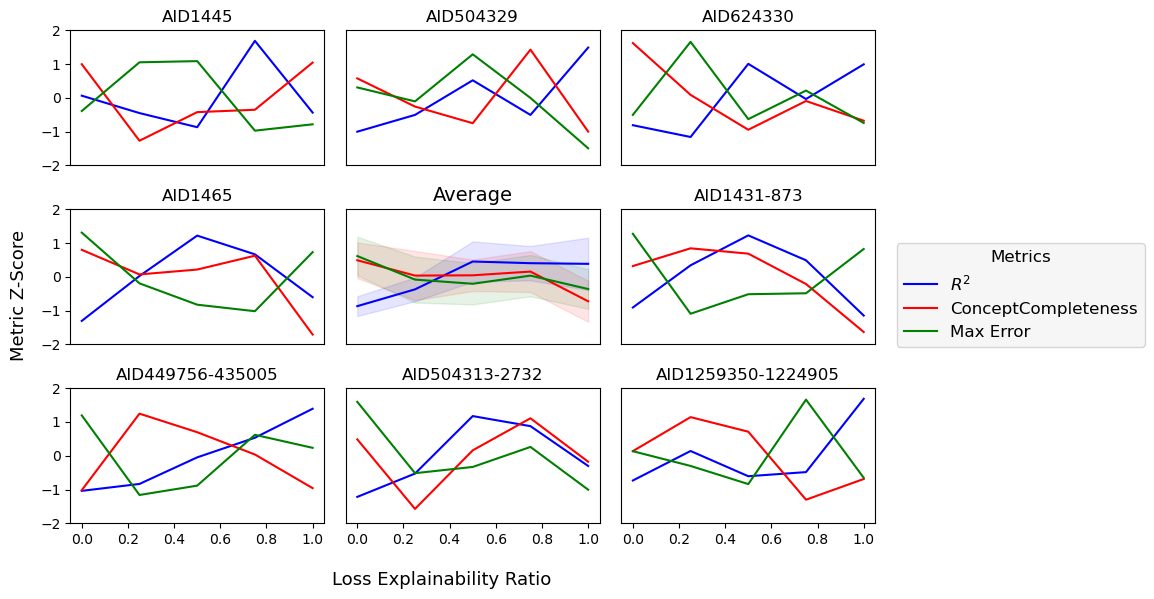

In [52]:
colours = {'PearsonCorrCoefSquared': 'blue', 'ConceptCompleteness': 'red', 'MaxError': 'green'}
xs = [0, 0.25, 0.5, 0.75, 1.0]
fig, axs = plt.subplots(3, 3, figsize=(9, 6))
fig_idxs = [0, 1, 2, 3, 5, 6, 7, 8]
for i, (ax_i, dataset) in enumerate(zip(fig_idxs, datasets)):
    ax = axs.flatten()[ax_i]
    ax.set_title(dataset)
    ax.set_ylim(-2, 2)
    for metric, values in scaled_metrics.items():
        ax.plot(xs, values[i], color=colours[metric])
    if ax_i < 6:
        ax.set_xticks([])
    if ax_i % 3 != 0:
        ax.set_yticks([])

# Calculate average
means = {}
upper_bounds = {}
lower_bounds = {}
for metric, values in scaled_metrics.items():
    mean, lower, upper = calculate_confidence_interval(values)
    means[metric] = mean
    lower_bounds[metric] = lower
    upper_bounds[metric] = upper

ax = axs[1][1]
ax.set_title('Average', size=14)
ax.set_ylim(-2, 2)
for metric in scaled_metrics:
    ax.plot(xs, means[metric], color=colours[metric], label=metric_nice_names[metric])
    ax.fill_between(xs, lower_bounds[metric], upper_bounds[metric], color=colours[metric], alpha=.1)
#ax.set_ylim(ymin=0)
ax.set_xticks([])
ax.set_yticks([])
fig.supxlabel('Loss Explainability Ratio', size=13)
fig.supylabel('Metric Z-Score', size=13)
fig.legend(loc='right', bbox_to_anchor=(1.29, 0.5), fancybox=True, title='Metrics', facecolor='#f4f4f4', title_fontsize=12, fontsize=12)
fig.tight_layout()
#fig.savefig(config.FIGURES_DIR / ('loss_explainability_tradeoff' + img_ext), bbox_inches='tight')

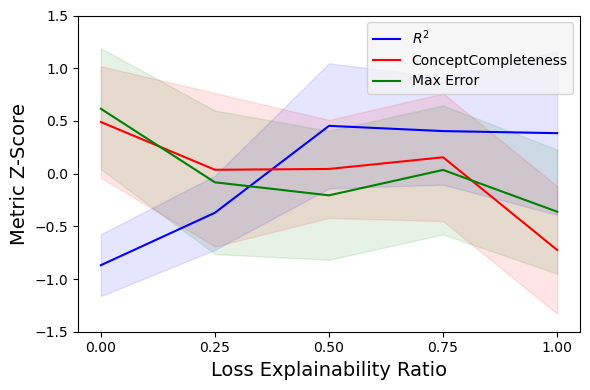

In [32]:
colours = {'PearsonCorrCoefSquared': 'blue', 'ConceptCompleteness': 'red', 'MaxError': 'green'}
xs = [0, 0.25, 0.5, 0.75, 1.0]
fig, ax = plt.subplots(figsize=(6, 4))

# Calculate average
means = {}
upper_bounds = {}
lower_bounds = {}
for metric, values in scaled_metrics.items():
    mean, lower, upper = calculate_confidence_interval(values)
    means[metric] = mean
    lower_bounds[metric] = lower
    upper_bounds[metric] = upper

for metric in scaled_metrics:
    ax.plot(xs, means[metric], color=colours[metric], label=metric_nice_names[metric])
    ax.fill_between(xs, lower_bounds[metric], upper_bounds[metric], color=colours[metric], alpha=.1)
ax.set_xlabel('Loss Explainability Ratio', size=14)
ax.set_ylabel('Metric Z-Score', size=14)
ax.set_xticks(xs, size=13)
ax.set_yticks(ax.get_yticks(), size=13)
ax.legend(loc='best', fontsize=10, fancybox=True, facecolor='#f4f4f4',)
fig.tight_layout()
fig.savefig(config.FIGURES_DIR / ('average_loss_explainability_tradeoff' + img_ext), bbox_inches='tight')

In [34]:
metrics_to_save = ['PearsonCorrCoefSquared', 'MaxError', 'ConceptCompleteness']
experiments = [
    'hyperopt_baseline_tpe_explainability',
    'hyperopt_joint_025_loss_explainability',
    'hyperopt_joint_05_loss_explainability',
    'hyperopt_joint_075_loss_explainability',
    'hyperopt_baseline_tpe',
]
metrics = defaultdict(lambda: defaultdict(list))
datasets = ['AID1445', 'AID504329', 'AID624330', 'AID1465', 'AID1431-873', 'AID449756-435005', 'AID504313-2732']

for dataset in datasets:
    for experiment in experiments:
        exp_dir = _get_log_dir(dataset, experiment, 'DROnly')
        result = read_json_file(exp_dir, 'best_architecture.json')
        result = list(result.values())[0]
        for metric in metrics_to_save:
            metrics[experiment][metric].append(result[metric])

In [35]:
print(metrics_to_save)
for experiment, results in metrics.items():
    print_str = experiment
    for metric, vs in results.items():
        vs = np.array(vs)
        mean = vs.mean()
        ci = 1.96 * vs.std() / math.sqrt(len(datasets))
        print_str += r' & {0:.3g} \pm {1:.3g}'.format(mean, ci)
    print(print_str)

['PearsonCorrCoefSquared', 'MaxError', 'ConceptCompleteness']
hyperopt_baseline_tpe_explainability & 0.259 \pm 0.162 & 1.36 \pm 0.41 & 0.124 \pm 0.0678
hyperopt_joint_025_loss_explainability & 0.335 \pm 0.174 & 1 \pm 0.269 & 0.129 \pm 0.0711
hyperopt_joint_05_loss_explainability & 0.455 \pm 0.203 & 1.05 \pm 0.31 & 0.131 \pm 0.0699
hyperopt_joint_075_loss_explainability & 0.459 \pm 0.138 & 1.01 \pm 0.364 & 0.125 \pm 0.0518
hyperopt_baseline_tpe & 0.367 \pm 0.154 & 1.1 \pm 0.332 & 0.167 \pm 0.0646


## Zero-cost Proxies
### Correlations

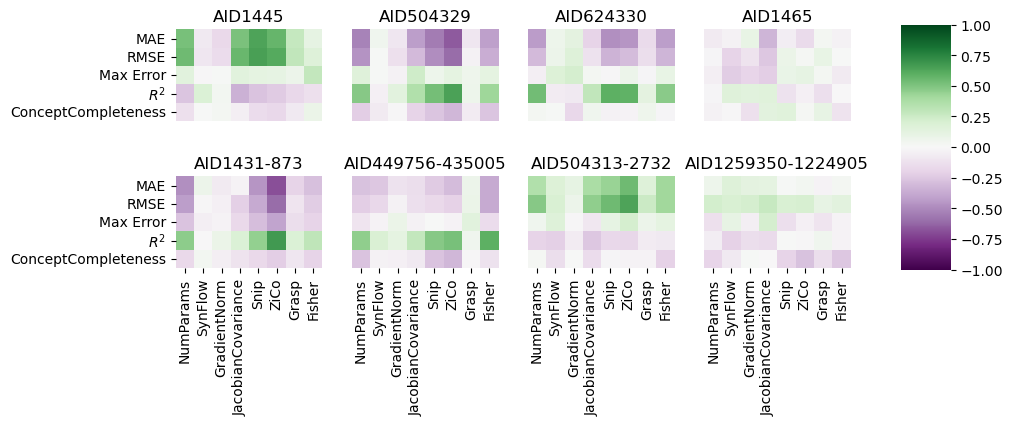

In [62]:
fig, axs = plt.subplots(2, 4, figsize=(10, 3.5))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
for i, (ax, dataset) in enumerate(zip(axs.flatten(), datasets)):
    ax.set_title(dataset)
    proxies, metrics = load_samples(dataset)
    proxies = {k: v.cpu().detach() for k, v in proxies.items()}
    metrics = {k: v.cpu().detach() for k, v in metrics.items()}
    experiment_df = pd.DataFrame(proxies | metrics)
    corrs = experiment_df.corr()
    corrs.loc['ConceptCompleteness', :] = - corrs.loc['ConceptCompleteness', :]
    sns.heatmap(
        corrs[proxy_names[:-2]].loc[metric_names, :].rename(metric_nice_names),
        xticklabels=i >= 4,
        yticklabels=i == 0 or i == 4,
        annot=False,
        square=True,
        ax=ax,
        cmap='PRGn',
        cbar_ax=cbar_ax,
        vmin=-1.0,
        vmax=1,
        center=0,
    )
fig.savefig(config.FIGURES_DIR / ('metric_proxy_correlations' + img_ext), bbox_inches='tight')

In [19]:
dataset_corrs = []
ensemble_ex_ps = defaultdict(list)
proxies_wo_novel = copy.deepcopy(DEFAULT_PROXIES)
del proxies_wo_novel.proxies['LatentSparsityGrad']
del proxies_wo_novel.proxies['ConceptPurityGrad']
for i, dataset in enumerate(datasets):
    proxies, metrics = load_samples(dataset)
    proxies_ex, metrics_ex = load_samples(dataset, True)
    proxies = {k: v.cpu().detach() for k, v in proxies.items()}
    metrics = {k: v.cpu().detach() for k, v in metrics.items()}
    proxies_ex = {k: v.cpu().detach() for k, v in proxies_ex.items()}
    metrics_ex = {k: v.cpu().detach() for k, v in metrics_ex.items()}
    experiment_df = pd.DataFrame(proxies_ex | metrics_ex)
    corrs = experiment_df.corr().abs()
    corrs = corrs[proxy_names].loc[metric_names, :]
    
    # Calculate Ensemble values
    ensemble_corrs = {}
    for metric in metric_names:
        ensemble = Ensemble(proxies_wo_novel)
        ensemble.fit(proxies, metrics[metric], not METRIC_HIGHER_IS_BETTER[metric])
        x = torch.stack([proxies[proxy] for proxy in ensemble.proxy_collection.proxies], dim=1)
        y = torch.tensor(ensemble.model.predict(x))
        r, p = pearsonr(y, metrics[metric])
        ensemble_corrs[metric] = abs(r)

        
    # Calculate Ensemble values
    ensemble_ex_corrs = {}
    for metric in metric_names:
        ensemble = Ensemble(DEFAULT_PROXIES)
        ensemble.fit(proxies_ex, metrics_ex[metric], not METRIC_HIGHER_IS_BETTER[metric])
        x = torch.stack([proxies_ex[proxy] for proxy in ensemble.proxy_collection.proxies], dim=1)
        y = torch.tensor(ensemble.model.predict(x))
        r, p = pearsonr(y, metrics_ex[metric].cpu())
        ensemble_ex_corrs[metric] = abs(r)
        ensemble_ex_ps[metric].append(p)
        
    corrs['Ensemble'] = pd.Series(ensemble_corrs)
    corrs['Ensemble + Novel'] = pd.Series(ensemble_ex_corrs)
    dataset_corrs.append(corrs)

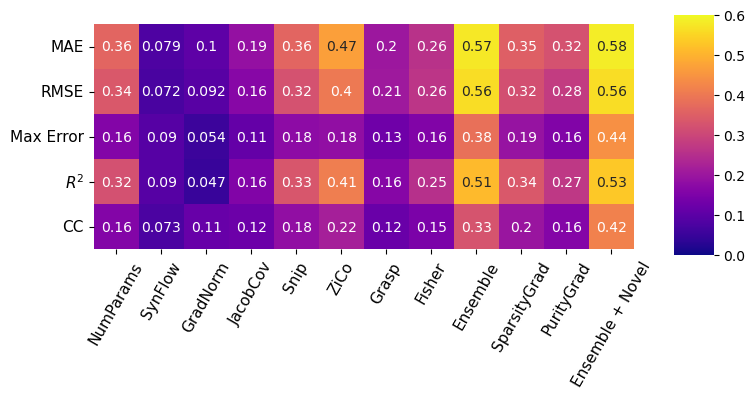

In [25]:
avg_corrs = sum(dataset_corrs) / len(dataset_corrs)
df_to_plot = avg_corrs.rename(columns={'GradientNorm': 'GradNorm', 'JacobianCovariance': 'JacobCov', 'LatentSparsityGrad': 'SparsityGrad', 'ConceptPurityGrad': 'PurityGrad'})
df_to_plot = df_to_plot.rename({'ConceptCompleteness':'CC'})
cols = list(df_to_plot.columns)
col_name = cols.pop(-2)
cols.insert(-3, col_name)
df_to_plot = df_to_plot.reindex(columns=cols)

fig, ax = plt.subplots(figsize=(8, 4))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.05, 0.6])

sns.heatmap(
    df_to_plot.rename(metric_nice_names),
    xticklabels=True,
    yticklabels=True,
    annot=True,
    square=True,
    ax=ax,
    cmap='plasma',
    cbar_ax=cbar_ax,
    vmin=0.0,
    vmax=0.6
) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)
fig.savefig(config.FIGURES_DIR / ('abs_metric_proxy_correlations' + img_ext), bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.05, 0.6])

sns.heatmap(
    df_to_plot.rename(metric_nice_names),
    xticklabels=True,
    yticklabels=True,
    annot=True,
    square=True,
    ax=ax,
    cmap='plasma',
    cbar_ax=cbar_ax,
    vmin=0.0,
    vmax=0.6
) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)
fig.savefig(config.FIGURES_DIR / ('icml_abs_metric_proxy_correlations' + img_ext), bbox_inches='tight')

In [24]:
# Average p values
{k: max(v) for k, v in ensemble_ex_ps.items()}

{'MeanAbsoluteError': 0.0018718466158349518,
 'RootMeanSquaredError': 0.005278342966025787,
 'MaxError': 0.0012793244406925184,
 'PearsonCorrCoefSquared': 0.0012635353236680352,
 'ConceptCompleteness': 0.0002014241948185933}

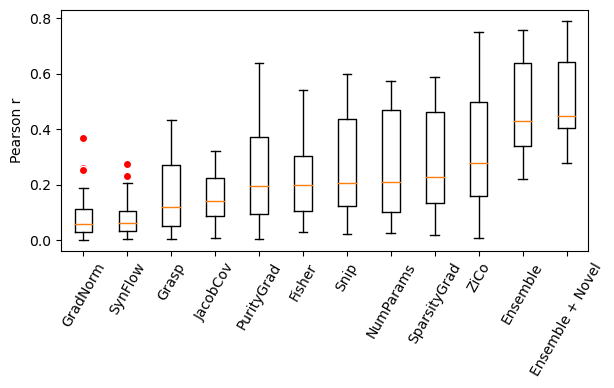

In [65]:
target = 'RootMeanSquaredError'
fig, ax = plt.subplots(figsize=(6, 3))
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
fig.tight_layout()
ax.set_ylabel('Pearson r')
data_to_plot = defaultdict(list)
for proxy in proxy_names + ['Ensemble'] + ['Ensemble + Novel']:
    data_to_plot[proxy].extend([x for corrs in dataset_corrs for x in corrs[proxy] ])  
df_to_plot = pd.DataFrame(data_to_plot)
df_to_plot = df_to_plot.rename(columns={'GradientNorm': 'GradNorm', 'JacobianCovariance': 'JacobCov', 'LatentSparsityGrad': 'SparsityGrad', 'ConceptPurityGrad': 'PurityGrad'})
df_to_plot = df_to_plot[df_to_plot.median().sort_values(ascending=True).index.values]
ax.boxplot(df_to_plot, flierprops=red_circle,widths=0.4)
ax.set_xticklabels(df_to_plot.columns, rotation=60)
fig.savefig(config.FIGURES_DIR / ('metric_proxy_box_plot' + img_ext), bbox_inches='tight')

### Proxy Fitting

In [40]:
min_samples = 2
max_samples = 50
dataset_losses = {}
proxies_wo_novel = copy.deepcopy(DEFAULT_PROXIES)
del proxies_wo_novel.proxies['LatentSparsityGrad']
del proxies_wo_novel.proxies['ConceptPurityGrad']
for dataset in datasets:
    proxies, metrics = load_samples(dataset)
    train_proxies = {k: v[:max_samples] for k, v in proxies.items()}
    train_metrics = {k: v[:max_samples] for k, v in metrics.items()}
    train_labels = train_metrics['RootMeanSquaredError']
    test_proxies = {k: v[max_samples:] for k, v in proxies.items()}
    test_metrics = {k: v[max_samples:] for k, v in metrics.items()}
    test_labels = test_metrics['RootMeanSquaredError']
    average_losses = torch.zeros((1, max_samples-min_samples + 1))
    for _ in range(5):
        idxs = list(range(len(train_labels)))
        np.random.shuffle(idxs)
        losses = []
        for i in range(min_samples, max_samples+1):
            ensemble = Ensemble(proxies_wo_novel)
            batch_idxs = idxs[:i]
            batch_proxies = {k:v[batch_idxs] for k,v in train_proxies.items()}
            batch_labels = train_labels[batch_idxs]
            ensemble.fit(batch_proxies, batch_labels, True)
            x = torch.stack([test_proxies[proxy] for proxy in ensemble.proxy_collection.proxies], dim=1)
            y = torch.tensor(ensemble.model.predict(x))
            losses.append(torch.mean((y.cpu() - test_labels.cpu()) ** 2).cpu().detach())
        average_losses += torch.tensor(losses)    
    dataset_losses[dataset] = average_losses / 5
    

In [41]:
losses = torch.cat([loss for loss in dataset_losses.values()], dim=0)
mins = losses.min(dim=1)[0].reshape(8, 1).expand(8, len(losses[0]))
maxs = losses.max(dim=1)[0].reshape(8, 1).expand(8, len(losses[0]))
losses = (losses - mins) / (maxs - mins)
means = torch.mean(losses, dim=0)
margin_of_error = 1.96 * torch.std(losses, dim=0) / len(datasets)
lower_bound = torch.clamp(means - margin_of_error, min=0)
upper_bound = means + margin_of_error

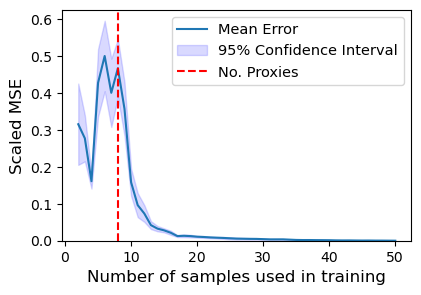

In [56]:
xs = list(range(min_samples, max_samples + 1))
fig, ax = plt.subplots(figsize=(4.5, 3))
ax.set_ylabel("Scaled MSE", fontsize=12)
ax.set_xlabel("Number of samples used in training", fontsize=12)
ax.plot(xs, means, label="Mean Error")
ax.fill_between(xs, lower_bound, upper_bound, color='b', alpha=.15, label="95% Confidence Interval")
ax.set_ylim(ymin=0)
ax.axvline(x=8, color='red', linestyle='--', label='No. Proxies')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper right', fontsize=10.5)
fig.savefig(config.FIGURES_DIR / ('ensemble_fitting' + img_ext), bbox_inches='tight')